### Multilayer perceptron для решения задачи многоклассовой классификации

Импортируем библиотеку глубокого обучения PyTorch.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np

Входные данные из датасета MNIST представляют из себя изображения рукописных цифр $28*28$ пикселей с оттенками серого.

Разбиваем данные для тренировки на выборки размера ```batch_size```, для тестирования на ```test_batch_size```.

In [3]:
batch_size = 64
test_batch_size = 1000

Для тренировки и тестирования используются разные данные. Тренировачный датасет разбиваем на 50000 для тренировки и 10000 для валидации. 

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

full_trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

indices = list(range(len(full_trainset)))
np.random.shuffle(indices)
train_idx, val_idx = indices[10000:], indices[:10000]

train_dataset = torch.utils.data.Subset(full_trainset, train_idx)
val_dataset = torch.utils.data.Subset(full_trainset, val_idx)

test_dataset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

Нарисуем по одному элементу из каждого датасета.

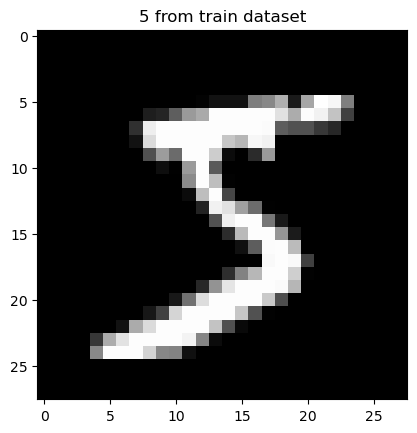

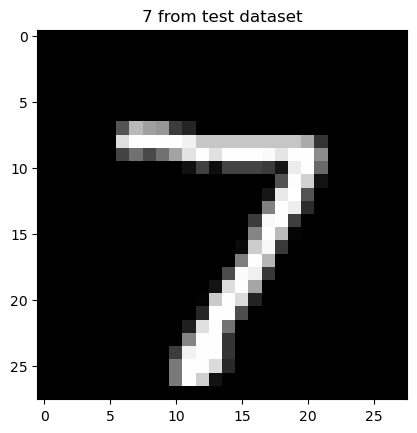

In [5]:
plt.imshow(full_trainset.data[0].numpy(), cmap='gray')
plt.title('%i from train dataset' % full_trainset.targets[0])
plt.show()
plt.imshow(test_dataset.data[0].numpy(), cmap='gray')
plt.title('%i from test dataset' % test_dataset.targets[0])
plt.show()

Если доступен GPU, выбираем его, иначе CPU.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Класс полносвязной нейронной сети:   
```input_size``` — размер входного слоя ($784$ для данной задачи)  
```num_classes``` — количество классов, или же размер выходного слоя ($10$ для данной задачи)  
```hidden_sizes``` — список размеров скрытых слоев  
Структура нейросети:
![](https://media.geeksforgeeks.org/wp-content/uploads/nodeNeural.jpg)

In [7]:
class MLP(nn.Module):

    def __init__(self, hidden_sizes=[], input_size=784, num_classes=10):
        super().__init__()
        self.input_size=input_size
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       nn.ReLU()]
        layers += [nn.Linear(layer_sizes[-1], num_classes), nn.Softmax(dim=-1)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for l in self.layers:
            x = l(x)
        return x

Входной слой состоит из $28*28 = 784$ узлов. Далее несколько скрытых слоев из произвольного количества узлов (далее протестируем несколько вариантов), использующих линейную выпрямительную функцию активации $ReLU(x) = max(0, x)$.  
Выходной слой с состоит из $10$ узлов с функцией активации $Softmax(x_i) = {exp(x_i) \over \sum_{j}^M exp(x_j)}$. Для каждого выхода дает значения в диапазоне [0; 1], при этом сумма всех выходов всегда равна 1. То есть, их можно интерпретировать как вероятности определения того или иного класса, поэтому часто используется в задачах многоклассовой классификации.  
Посмотрим на сеть с двумя спрятанными слоями по $256$ и $128$ узлов.

In [8]:
print(MLP([128, 128]))

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=-1)
  )
)


Начнем тренировку сети.
Задаем функцию потерь как функцию перекрёстной энтропии (CrossEntropyLoss). $$CrossEntropyLoss(p, q) = -\sum_{x} {p(x) log{(q(x))} + (1 - p(x)) log{(1 - q(x))}}$$  
Ее используют для количественной оценки разницы между двумя распределениями вероятностей.

In [9]:
criterion = nn.CrossEntropyLoss()

Внешний тренировочный цикл проходит по количеству эпох ```epochs```.

In [10]:
epochs=6

Для обучения используем ```optim.Adam``` - это популярный оптимизатор в PyTorch, который сочетает преимущества методов моментума и нормализации градиентов. Он особенно эффективен для глубокого обучения благодаря адаптивному управлению скоростью обучения для каждого параметра модели.
Скорость обучения ```learning_rate``` определяет, насколько быстро нейронная сеть будет сходиться к минимумам.

In [11]:
learning_rate=0.001

Во время тренировки данные извлекаются из объекта загрузки данных ```train_loader```.  
Внутренний цикл проходиться по выборкам, на которые ранее были разбиты данные, и для каждой выборки считает получившиеся на выходе сети значения ```net_out```.  
Относительно ожидаемого результата ```target``` вычисляется значение потери ```loss```.  
```loss.backward()``` запускает операцию обратного распространения ошибки из переменной потери в обратном направлении через нейросеть.   
```optimizer.step()``` выполняет градиентный спуск по шагам на основе вычисленных во время предыдущей операции градиентов.
В конце каждой эпохи тестируем модель на другом наборе данных и запоминаем точность.

In [12]:
def validate(model):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
    
    accuracy = correct / len(val_loader.dataset)
    val_loss /= len(val_loader)
    return (val_loss, accuracy)

In [13]:
def train(model):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    train_info = []
    val_info = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target)
            train_loss += loss.item()
            loss.backward()

            optimizer.step()
        train_loss /= len(train_loader)    
        train_info += [train_loss]
        scheduler.step()
        val_loss = validate(model)[0]
        val_info += [val_loss]
        
    return (train_info, val_info, test(model))

Тестируем нейросеть. Подаем данные на вход нейросети, считаем потери и количество верно предсказанных тестов. Возвращаем точность.

In [14]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
    
    accuracy = correct / len(test_loader.dataset)
    test_loss /= len(test_loader)
    return accuracy

Построим графики потери на тестовых и валидационных данных по нескольким запускам. Учитываем среднее значение и стандартное отклонение.

In [15]:
def build_plot_loss_mean(info, subplt=0, title=""):
    if subplt!=0:
        plt.subplot(subplt)
    if title != "":
        plt.title(title)

    train_info = []
    val_info = []
    for i in info:
        train_info += [i[0]]
        val_info += [i[1]]

    train_mean = np.array(np.stack(train_info)).mean(axis=0)
    train_std = np.array(np.stack(train_info)).std(axis=0)
    plt.plot(range(1, len(train_mean) + 1), train_mean, color='red', label='train')
    plt.fill_between(range(1, len(train_mean) + 1), train_mean - train_std, train_mean + train_std, color='red', alpha=0.4)
    
    val_mean = np.array(np.stack(val_info)).mean(axis=0)
    val_std = np.array(np.stack(val_info)).std(axis=0)
    plt.plot(range(1, len(val_mean) + 1), val_mean, color='blue', label='validation')
    plt.fill_between(range(1, len(val_mean) + 1), val_mean - val_std, val_mean + val_std, color='blue', alpha=0.4)
    

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

In [59]:
def build_plot_loss_mean_many(infom, labels, title=""):
    if title != "":
        plt.title(title)
        
    colors = ['red', 'green', 'blue', 'orange', 'yellow']
    j = 0
    for info in infom:
        train_info = []
        val_info = []
        for i in info:
            train_info += [i[0]]
            val_info += [i[1]]

        train_mean = np.array(np.stack(train_info)).mean(axis=0)
        train_std = np.array(np.stack(train_info)).std(axis=0)
        plt.plot(range(1, len(train_mean) + 1), train_mean, color=colors[j], label=labels[j], alpha=0.9)
        plt.fill_between(range(1, len(train_mean) + 1), train_mean - train_std, train_mean + train_std, color=colors[j], alpha=0.4)
        j += 1

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

In [53]:
def build_plot_acc_mean(info, title=""):
    if title != "":
        plt.title(title)

    acc = []
    for i in info:
        acc += [[x[2] * 100 for x in i]]
    mean = np.array(np.stack(acc)).mean(axis=1)
    std = np.array(np.stack(acc)).std(axis=1)
    plt.plot(range(1, len(mean) + 1), mean, color='black', label='train')
    plt.fill_between(range(1, len(mean) + 1), mean - std, mean + std, color='black', alpha=0.4)
    plt.xticks(range(1, len(mean) + 1))
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Number of hidden layers', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

In [18]:
info60 = [
    [train(MLPb([60])) for _ in range(10)],
    [train(MLPb([30, 30])) for _ in range(10)],
    [train(MLPb([20, 20, 20])) for _ in range(10)],
    [train(MLPb([15, 15, 15, 15])) for _ in range(10)],
    [train(MLPb([12, 12, 12, 12, 12])) for _ in range(10)]
]

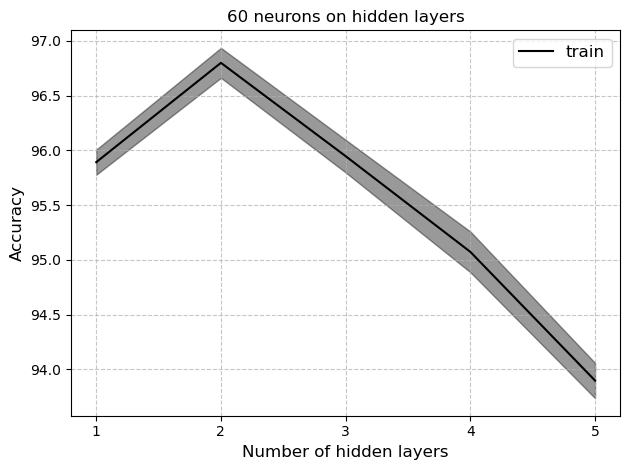

In [63]:
build_plot_acc_mean(info60, title='60 neurons on hidden layers')

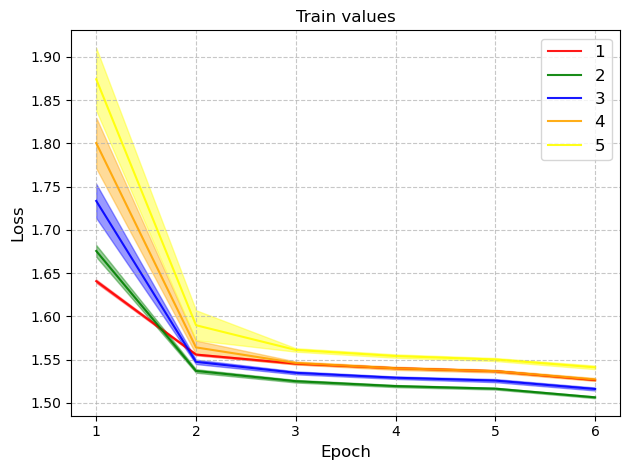

In [64]:
build_plot_loss_mean_many(info60, labels=['1', '2', '3', '4', '5'], title="Train values")

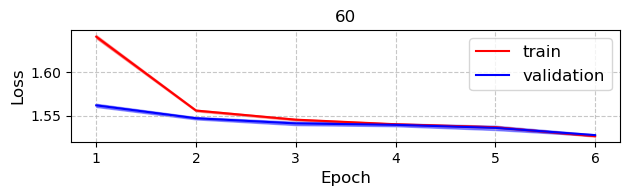

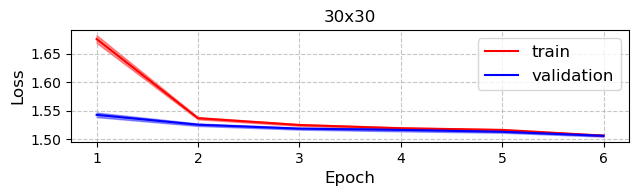

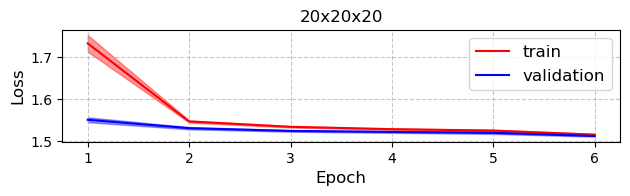

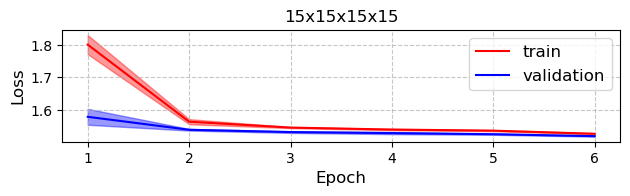

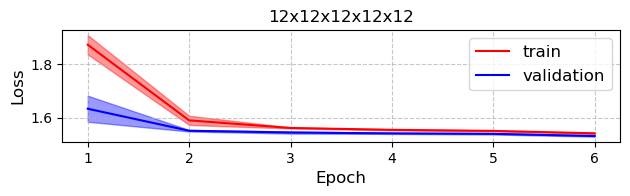

In [65]:
build_plot_loss_mean(info60[0], subplt=313, title="60")
build_plot_loss_mean(info60[1], subplt=313, title="30x30")
build_plot_loss_mean(info60[2], subplt=313, title="20x20x20")
build_plot_loss_mean(info60[3], subplt=313, title="15x15x15x15")
build_plot_loss_mean(info60[4], subplt=313, title="12x12x12x12x12")

In [55]:
info120 = [
    [train(MLPb([120])) for _ in range(5)],
    [train(MLPb([60, 60])) for _ in range(5)],
    [train(MLPb([40, 40, 40])) for _ in range(5)],
    [train(MLPb([30, 30, 30, 30])) for _ in range(5)],
    [train(MLPb([24, 24, 24, 24, 24])) for _ in range(5)]
]

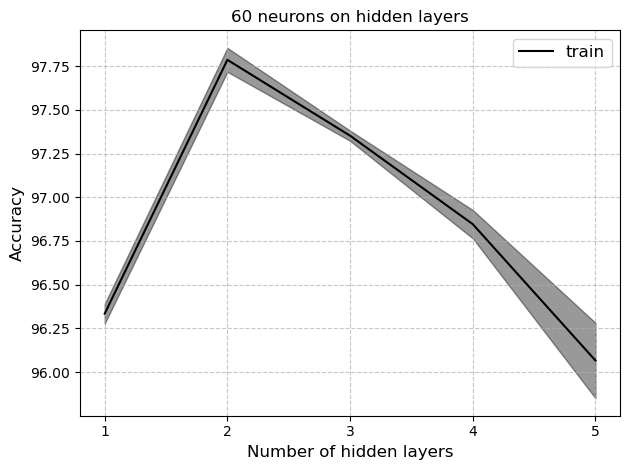

In [58]:
build_plot_acc_mean(info120, title='120 neurons on hidden layers')

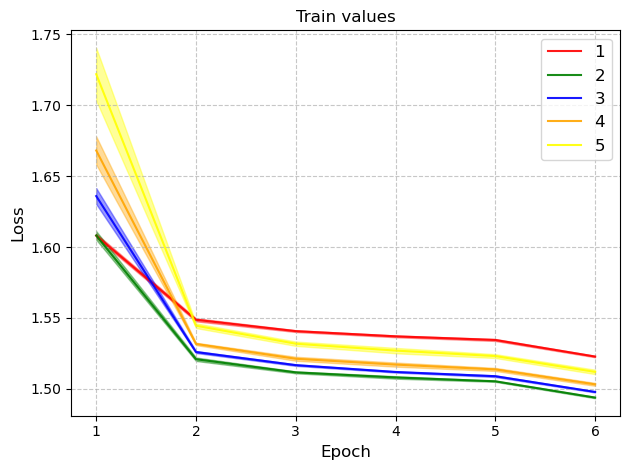

In [60]:
build_plot_loss_mean_many(info120, labels=['1', '2', '3', '4', '5'], title="Train values")

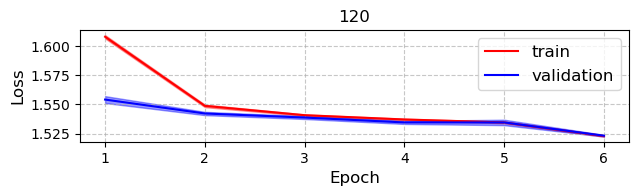

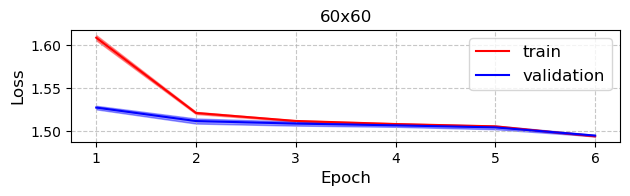

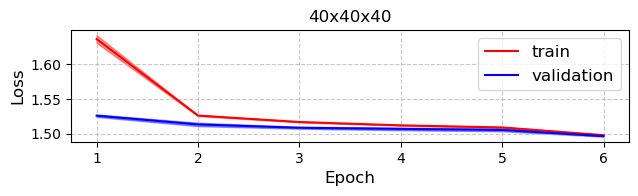

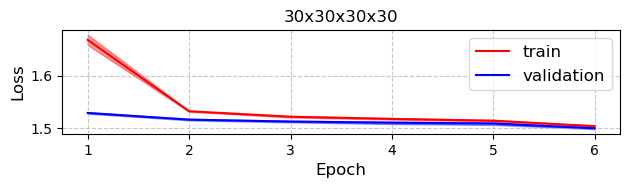

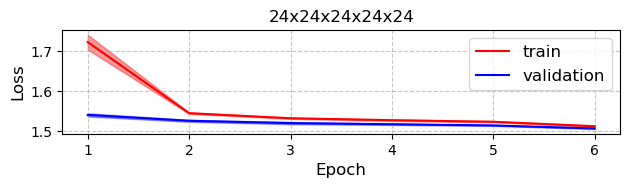

In [61]:
build_plot_loss_mean(info120[0], subplt=313, title="120")
build_plot_loss_mean(info120[1], subplt=313, title="60x60")
build_plot_loss_mean(info120[2], subplt=313, title="40x40x40")
build_plot_loss_mean(info120[3], subplt=311, title="30x30x30x30")
build_plot_loss_mean(info120[4], subplt=311, title="24x24x24x24x24")

In [62]:
d13 = [train(MLPb([12, 12, 12, 12, 12])) for _ in range(10)]

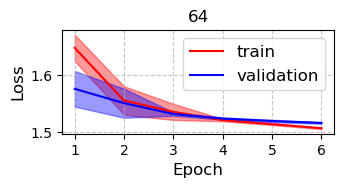

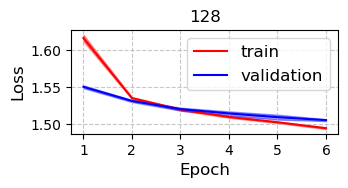

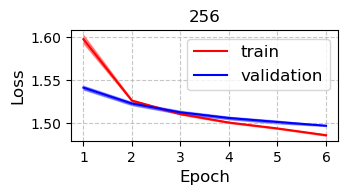

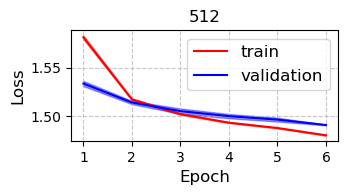

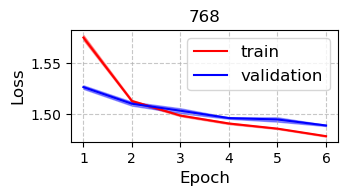

In [218]:
build_plot_loss_mean(info3, subplt=321, title="64")
build_plot_loss_mean(info5, subplt=322, title="128")
build_plot_loss_mean(info9, subplt=323, title="256")
build_plot_loss_mean(info11, subplt=324, title="512")
build_plot_loss_mean(info13, subplt=325, title="768")

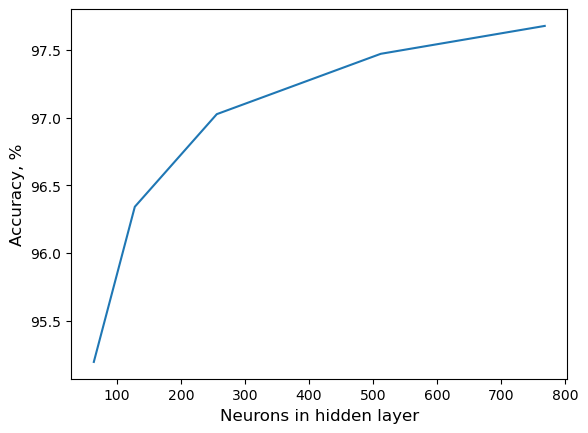

In [219]:
plt.plot([64, 128, 256, 512, 768], [np.array([x[2] for x in i]).mean() * 100 for i in [info3, info5, info9, info11, info13]])
plt.ylabel('Accuracy, %', fontsize=12)
plt.xlabel('Neurons in hidden layer', fontsize=12)
plt.show()

In [123]:
info12 = [train(MLP([256, 256])) for _ in range(8)]

0.9726625


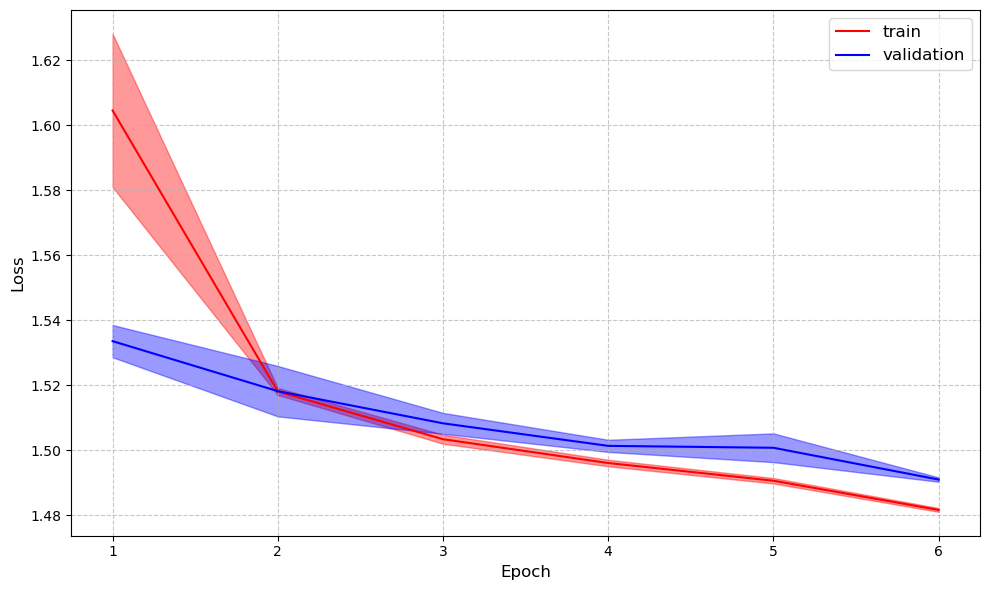

In [125]:
print(np.array([x[2] for x in info12]).mean())
build_plot_loss_mean(info12)

In [132]:
info15 = [train(MLP([512, 512])) for _ in range(8)]

0.9747375


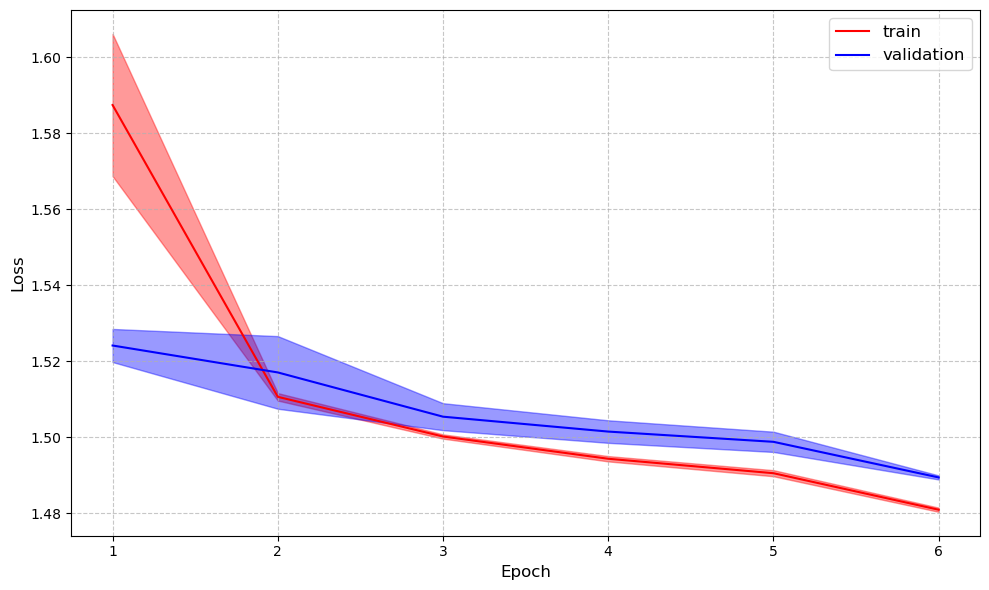

In [133]:
print(np.array([x[2] for x in info15]).mean())
build_plot_loss_mean(info15)

In [17]:
class MLPb(nn.Module):

    def __init__(self, hidden_sizes=[], input_size=784, num_classes=10):
        super().__init__()
        self.input_size=input_size
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       nn.BatchNorm1d(layer_sizes[layer_index]),
                       nn.ReLU()]
        layers += [nn.Linear(layer_sizes[-1], num_classes), nn.Softmax(dim=-1)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for l in self.layers:
            x = l(x)
        return x

In [208]:
print(MLP([512]))

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
    (4): Softmax(dim=-1)
  )
)


In [136]:
info17 = [train(MLP([512])) for _ in range(8)]

97.98


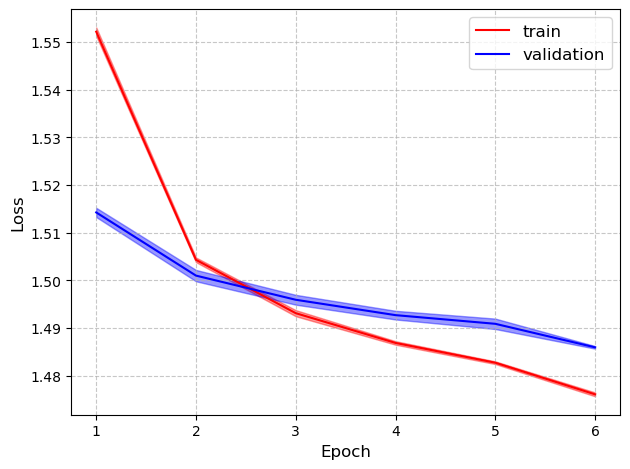

In [221]:
print(np.array([x[2] for x in info17]).mean() * 100)
build_plot_loss_mean(info17)

In [209]:
class MLP(nn.Module):

    def __init__(self, hidden_sizes=[], input_size=784, num_classes=10):
        super().__init__()
        self.input_size=input_size
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       nn.ReLU(),
                       nn.BatchNorm1d(layer_sizes[layer_index]),
                       nn.Dropout(0.2)]
        layers += [nn.Linear(layer_sizes[-1], num_classes), nn.Softmax(dim=-1)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for l in self.layers:
            x = l(x)
        return x

In [210]:
print(MLP([512]))

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): Softmax(dim=-1)
  )
)


In [177]:
info24 = [train(MLPBatchNormDrpt([512])) for _ in range(8)]

In [180]:
info25 = [train(MLPBatchNormDrpt([512], p=0.3)) for _ in range(8)]

In [182]:
info26 = [train(MLPBatchNormDrpt([512], p=0.4)) for _ in range(8)]

In [184]:
info27 = [train(MLPBatchNormDrpt([512], p=0.5)) for _ in range(8)]

0.9771


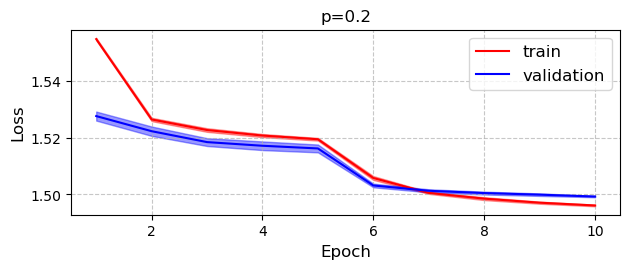

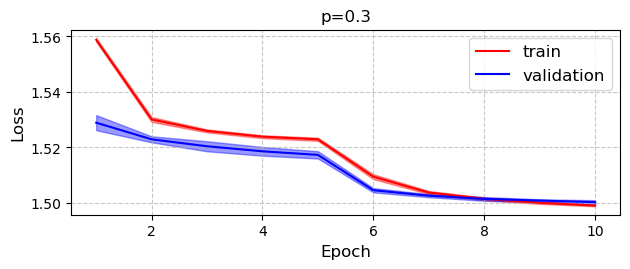

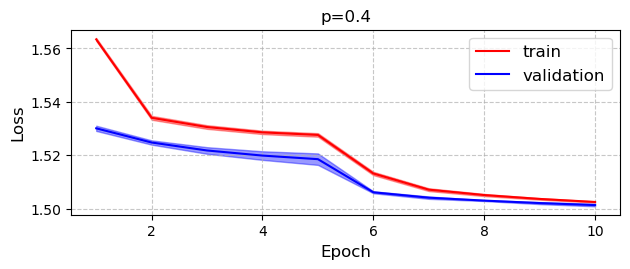

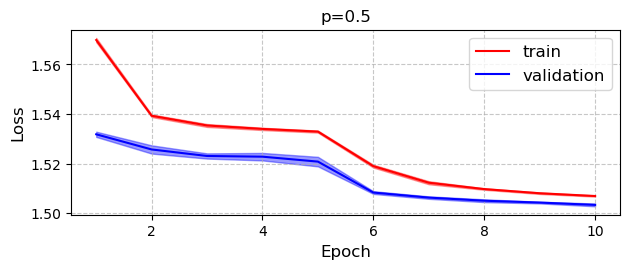

In [215]:
build_plot_loss_mean(info24, 211, title="p=0.2")
build_plot_loss_mean(info25, 212, title="p=0.3")
build_plot_loss_mean(info26, 211, title="p=0.4")
build_plot_loss_mean(info27, 212, title="p=0.5")

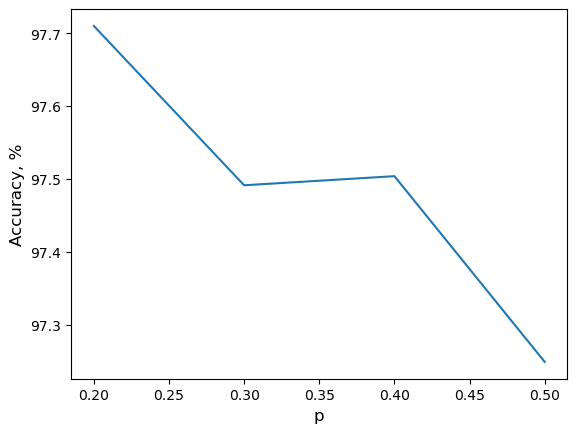

In [217]:
plt.plot([0.2, 0.3, 0.4, 0.5], [np.array([x[2] for x in i]).mean() * 100 for i in [info24, info25, info26, info27]])
plt.ylabel('Accuracy, %', fontsize=12)
plt.xlabel('p', fontsize=12)
plt.show()

In [229]:
print(f'Accuracy = {np.array([x[2] for x in info11]).mean() * 100}%')
print(f'Accuracy with BatchNorm = {np.array([x[2] for x in info17]).mean() * 100}%')
print(f'Accuracy with BatchNorm and Dropout = {np.array([x[2] for x in info24]).mean() * 100}%')

Accuracy = 97.4725%
Accuracy with BatchNorm = 97.98%
Accuracy with BatchNorm and Dropout = 97.71%
